# Imports

In [1]:
# System imports
import os
import sys
from pathlib import Path
# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
import seaborn as sn
# Pytorch imports
import torch 
import torch.nn as nn
import torch.nn.functional as F
# Vision imports
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler

# Random
import random
# TQDM
import tqdm
from torchsummary import summary
import gc

os.chdir('..') 
print(os.getcwd())

from Scripts.data_setup import create_dataloaders, create_dataloaders_with_validation_set
from Scripts.engine import *
# setting up device agnostics
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Setting number of works and directories for data
NUM_WORKERS = os.cpu_count()
TRAIN_DIR = "Data/train/"
TEST_DIR = "Data/test/"
DATA_DIR = "Data"




TRAINING_MODEL_NUMBER = 0



data_augmentation_transform = data_transforms_train = transforms.Compose([
        transforms.RandomRotation(20),  # Randomly rotate the image within a range of (-20, 20) degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),  # Randomly crop the image and resize it
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),  # Randomly apply affine transformations with translation
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),  # Randomly apply perspective transformations
        transforms.Resize(size=(256 ,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])


test_data_transform = transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

c:\Computational\Learning-Machine-Learning\PneumoniaCVProblem-1


c:\Users\jackg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transfer learning

Transfer learning is a powerful tool that can be used to increase the power of a network classifier without the need for the computationally expensive task of training a CNN. Transfer learning works by using a base pre trained model and modifying it for our classifcation task (how you do this depends on the model).#

For this we will use EfficentnetV2 S and will first get a baseline accuracy and f1score for us to improve on. This base line will be run direclty on the unedited 256x256 images.  The effnet model has been adapted for a binary classifacation problem and we will run 3 epoches to train the last layer.

In [2]:
import torchvision.models as models

effnetdefaultmodel = models.efficientnet_v2_s(weights = models.efficientnet_v2_s)
for param in effnetdefaultmodel.parameters():
    param.requires_grad = False
num_features = effnetdefaultmodel.classifier[1].in_features
effnetdefaultmodel.classifier[1] = nn.Linear(num_features, 2)

summary(effnetdefaultmodel, (3, 256, 256), device  = "cpu")

c:\Users\jackg\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]             648
       BatchNorm2d-2         [-1, 24, 128, 128]              48
              SiLU-3         [-1, 24, 128, 128]               0
            Conv2d-4         [-1, 24, 128, 128]           5,184
       BatchNorm2d-5         [-1, 24, 128, 128]              48
              SiLU-6         [-1, 24, 128, 128]               0
   StochasticDepth-7         [-1, 24, 128, 128]               0
       FusedMBConv-8         [-1, 24, 128, 128]               0
            Conv2d-9         [-1, 24, 128, 128]           5,184
      BatchNorm2d-10         [-1, 24, 128, 128]              48
             SiLU-11         [-1, 24, 128, 128]               0
  StochasticDepth-12         [-1, 24, 128, 128]               0
      FusedMBConv-13         [-1, 24, 128, 128]               0
           Conv2d-14           [-1, 96,

In [3]:
if TRAINING_MODEL_NUMBER == 50:
    gc.collect()
    torch.cuda.empty_cache()
    train_data , test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, test_data_transform, 64, NUM_WORKERS)
    print(DEVICE)

    effnetdefaultmodel.to(DEVICE)

    loss_func = torch.nn.CrossEntropyLoss()
   
    train_model(train_data, test_data, effnetdefaultmodel, loss_func, epoches = 3)

    evalutation_model(effnetdefaultmodel, test_data, loss_func)


Base line mode got the following statistics:
* F1_Score = 86%
* Accuracy = 81%

## Data augmentation + Data balancing

We will now train the final layer using both data augmentation and data balancing to see what effect that has on its accuracy.

For this I will use the same model - for arguments sake I don't think the 3 epoches trained on the un augmentad data will give it any performance boost and I dont want to have to load it again.

In [4]:
if TRAINING_MODEL_NUMBER == 51:
    gc.collect()
    torch.cuda.empty_cache()
    _ , test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, test_data_transform, 64, NUM_WORKERS)
    train_data, _ = create_dataloaders(TRAIN_DIR, TEST_DIR , data_augmentation_transform, 64, NUM_WORKERS, sampler = True)

    print(DEVICE)

    effnetdefaultmodel.to(DEVICE)

    loss_func = torch.nn.CrossEntropyLoss()
   
    train_model(train_data, test_data, effnetdefaultmodel, loss_func, epoches = 3)

    evalutation_model(effnetdefaultmodel, test_data, loss_func)


Massive improvements just from balancing and data augmentation alone, 7% accuracy increase.

* f1score - 90%
* Accuracy - 87%

## Data augmentation + balance load  + 224x 224 image size

Just going to look at the effect of creasing image size to 224, if it doesnt increase we will stick with 256.

In [5]:

data_augmentation_transform_224 = data_transforms_train = transforms.Compose([
        transforms.RandomRotation(20),  # Randomly rotate the image within a range of (-20, 20) degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop the image and resize it
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),  # Randomly apply affine transformations with translation
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),  # Randomly apply perspective transformations
        transforms.Resize(size=(224 ,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])


test_data_transform_224 = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

if TRAINING_MODEL_NUMBER == 52:
    gc.collect()
    torch.cuda.empty_cache()
    _ , test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, test_data_transform_224, 64, NUM_WORKERS)
    train_data, _ = create_dataloaders(TRAIN_DIR, TEST_DIR , data_augmentation_transform_224, 64, NUM_WORKERS, sampler = True)

    print(DEVICE)

    effnetdefaultmodel.to(DEVICE)

    loss_func = torch.nn.CrossEntropyLoss()
   
    train_model(train_data, test_data, effnetdefaultmodel, loss_func, epoches = 3)

    evalutation_model(effnetdefaultmodel, test_data, loss_func)


Accuracy and f1 score decrease from chanign image size, so will stick with 256.

## Increasing training time

We will now train back on our 256x256 images and train it for longer increasing it to 10 epoches instead.

In [6]:
import gc
if TRAINING_MODEL_NUMBER == 53:
    gc.collect()
    torch.cuda.empty_cache()
    _ , test_data = create_dataloaders(TRAIN_DIR, TEST_DIR, test_data_transform, 64, NUM_WORKERS)
    train_data, _ = create_dataloaders(TRAIN_DIR, TEST_DIR , data_augmentation_transform, 64, NUM_WORKERS, sampler = True)

    print(DEVICE)

    effnetdefaultmodel.to(DEVICE)

    loss_func = torch.nn.CrossEntropyLoss()
   
    train_model(train_data, test_data, effnetdefaultmodel, loss_func, epoches = 10)

    evalutation_model(effnetdefaultmodel, test_data, loss_func)


Slight increase in performacne from the longer training.

* F1score - 90%
* Accuracy - 87%

This is a 7% accuracy increase over the base model.

## Learning rate schedular

Another way to help training is by using a learning rate scedular, this helps adapt the learning rate as it trains.

cuda
{'T_max': 20}


c:\Users\jackg\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 | train_loss: 0.5395 | train_acc: 0.7431 | test_loss: 0.4910 | test_acc: 0.8530
Epoch: 2 | train_loss: 0.3858 | train_acc: 0.8624 | test_loss: 0.4102 | test_acc: 0.8649
Epoch: 3 | train_loss: 0.3173 | train_acc: 0.8868 | test_loss: 0.2899 | test_acc: 0.9104
Epoch: 4 | train_loss: 0.2702 | train_acc: 0.9029 | test_loss: 0.2828 | test_acc: 0.8957
Epoch: 5 | train_loss: 0.2690 | train_acc: 0.9003 | test_loss: 0.2472 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.2536 | train_acc: 0.9076 | test_loss: 0.2603 | test_acc: 0.8979
Epoch: 7 | train_loss: 0.2422 | train_acc: 0.9102 | test_loss: 0.2423 | test_acc: 0.8985
Epoch: 8 | train_loss: 0.2305 | train_acc: 0.9114 | test_loss: 0.2413 | test_acc: 0.9088
Epoch: 9 | train_loss: 0.2159 | train_acc: 0.9198 | test_loss: 0.2180 | test_acc: 0.9112
Epoch: 10 | train_loss: 0.2179 | train_acc: 0.9157 | test_loss: 0.2791 | test_acc: 0.8953


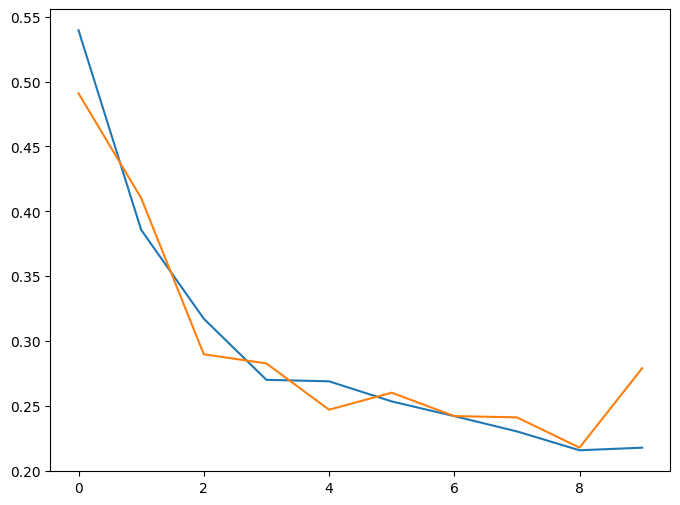

The test f1 score of this model is 0.8938271604938272
The test accuracy of this model is 0.8621794871794872


In [7]:
TRAINING_MODEL_NUMBER = 55
if TRAINING_MODEL_NUMBER == 55:
    gc.collect()
    torch.cuda.empty_cache()
    train_data, val_data, test_data = create_dataloaders_with_validation_set(TRAIN_DIR, TEST_DIR, data_augmentation_transform, test_data_transform, 256, NUM_WORKERS)
    print(DEVICE)

    effnetdefaultmodel.to(DEVICE)
    optimiser_schedular = torch.optim.lr_scheduler.CosineAnnealingLR

    loss_func = torch.nn.CrossEntropyLoss()
   
    train_model(train_data, val_data, effnetdefaultmodel, loss_func, epoches = 10, schedular= optimiser_schedular, schdular_paras=  {"T_max" : 20} )

    evalutation_model(effnetdefaultmodel, test_data, loss_func)


Gives f1 score of 89% and an accuracy of 86%, could potentially work well with some tweaks to it.